# Understanding VariantNET
This is a Python 2 notebook where we will be taking code samples from [Jason Chin's VariantNet repository](https://github.com/pb-jchin/VariantNET). Finding out how data is loaded and the VariantNET itself is implemented - while proposing an alternative neural net.

A digest of points to be covered:
<ul>
    <li>Loading and Parsing Data</li>
    <li>Designing Models to Train Data</li>
    <li>Evaluating Model Effectivity</li>
    <li>Proposals for future development</li>
</ul>

In [1]:
# for plotting to visualize some data
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


We'll start by looking at the formats of the data that are imported to train VariantNET and how they are parsed by VariantNet's utils. In the demo notebook - we can see that a single command `get_training_data` is used to return two numpy.ndarrays which stores training data and training labels how we would expect if we were to use this data to train a scikit-learn model.

In more detail, the command that imports the data is:

```python
Xarray, Yarray, pos_array = \
utils.get_training_array("../wd/aln_tensor_chr21", 
                         "../wd/variants_chr21", 
                         "../testing_data/chr21/CHROM21_v.3.3.2_highconf_noinconsistent.bed" )
```

Let's have a look at the files used in calling the function and see how they fit together to return the numpy ndarrays, that we can use for convenient training.

In [2]:
import numpy as np

import sys
sys.path.append('../')

with open('../wd/aln_tensor_chr21','r') as f:
    line = f.readline()
    print line

14060179 GCCCCCAACAGTACC 0.0 0.0 9.0 0.0 1.0 0.0 8.0 0.0 1.0 0.0 8.0 0.0 0.0 9.0 0.0 0.0 0.0 7.0 1.0 1.0 0.0 7.0 1.0 1.0 0.0 9.0 0.0 0.0 0.0 8.0 1.0 0.0 0.0 8.0 1.0 0.0 0.0 10.0 0.0 0.0 0.0 10.0 0.0 0.0 0.0 10.0 0.0 0.0 0.0 10.0 0.0 0.0 0.0 9.0 0.0 1.0 0.0 9.0 0.0 1.0 0.0 10.0 0.0 0.0 1.0 9.0 0.0 0.0 1.0 9.0 0.0 0.0 10.0 0.0 0.0 0.0 9.0 1.0 0.0 0.0 9.0 1.0 0.0 0.0 10.0 0.0 0.0 0.0 8.0 2.0 0.0 0.0 8.0 2.0 0.0 0.0 0.0 10.0 0.0 0.0 0.0 9.0 0.0 1.0 0.0 9.0 0.0 1.0 10.0 0.0 0.0 0.0 9.0 0.0 1.0 0.0 9.0 0.0 1.0 0.0 0.0 0.0 10.0 0.0 0.0 0.0 10.0 0.0 0.0 0.0 10.0 0.0 0.0 0.0 0.0 9.0 0.0 0.0 0.0 9.0 0.0 0.0 0.0 9.0 10.0 0.0 0.0 0.0 10.0 0.0 0.0 0.0 10.0 0.0 0.0 0.0 0.0 8.0 0.0 0.0 0.0 8.0 0.0 0.0 0.0 8.0 0.0 0.0 0.0 10.0 0.0 0.0 1.0 9.0 0.0 0.0 1.0 9.0 0.0 0.0



To understand this data format fully, we must refer to Chin's [Medium article](https://towardsdatascience.com/simple-convolution-neural-network-for-genomic-variant-calling-with-tensorflow-c085dbc2026f). In it is stated:

> For each candidate, we add 7 base flanking bases on both side.

After checking in `utils.py`, we can confirm that the first number is the position of the candidate base. And the length of the sequence being 15 bases agrees with a single base being padded with 7 bases either side $(7+7+1=15)$.

Finally we are left with what appears to be 180 arbitrary floats. Again checking with how `utils.py` functions, this encodes information which holds both the reference sequence in a one-hot encoded matrix and two other one-hot encoded matrices which show disparity between reference sequence and sequencer data.

This gives us a way to display the above file in a format that we see in Chin's article.

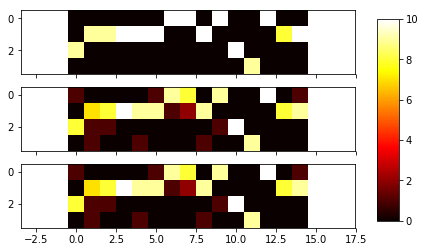

In [3]:
line_list = line.strip().split()
ref_seq = line_list[1]

reshaped = np.reshape(np.array([float(i) for i in line_list[2:]]),
                      (15,3,4))

fig, axarr = plt.subplots(3,sharey=True,sharex=True)

for i in range(3):
    im = axarr[i].imshow(reshaped[:,i,:].T,cmap='hot')
    
cbar_ax = fig.add_axes([0.95, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

As described in the Medium article:

> We summary the alignment information into three 15 x 4 matrices... One matrix track the baseline encoding the reference sequence and the number of supported reads through a position. Two other 15 by 4 matrix track the differences between the sequencing data and the references.

The differences between sequencing data and references isn't apparent here, since the reference hasn't been subtracted from the sequencing data. However, this is how it present in the train data below.

Next, let us analyze `"../wd/variants_chr21"`

In [4]:
with open('../wd/variants_chr21','r') as f:
    lines = f.readlines()[:10]
    for line in lines:
        print line

10270925 T A 0 1

12996850 C G 0 1

14069696 T A 0 1

14069739 G A 0 1

14071090 C A 0 1

14071143 T G 0 1

14071850 ATC T 1 1

14071923 C CCCCCCT 0 1

14071983 T G 1 1

14072221 G A 0 1



As the name suggests we have some obvious variants here. When we read `utils.py`, we have this code snippet with regards to how this data is parsed:

```python
for row in f:
            row = row.strip().split()
            if row[3] == "0":
                het = True
            else:
                het = False
```

This indicates that the second number from the left determines whether or not the described variant is heterozygous. Delving deeper, the variants in this file are split in VariantNET into 4 categories - heterozygous, homozygous and non-SNP (this is for cases with multiple polymorphisms longer than a single base).

We are now ready to explore the final file used to generate training data: `../testing_data/chr21/CHROM21_v.3.3.2_highconf_noinconsistent.bed`

In [5]:
with open("../testing_data/chr21/CHROM21_v.3.3.2_highconf_noinconsistent.bed",'r') as f:
    lines = f.readlines()[:10]
    for line in lines:
        print line

chr21	10269870	10269950

chr21	10270051	10270144

chr21	10270409	10270716

chr21	10270914	10271075

chr21	10271176	10271201

chr21	10271390	10271604

chr21	10272048	10272058

chr21	10272350	10272468

chr21	10272569	10273022

chr21	10273193	10273450



The data encodes from left to right, chromosomal location of a known variant, beginning and end sequence locations of known variants.

Using a combination of all these three we are able to get a full set of training data for VariantNet. As we will now see in the break down of `get_training_data` in `utils.py`.

In [6]:
#This provides a simple one-hot encoder for base-letters
base2num = dict(zip("ACGT",(0, 1, 2, 3)))

import intervaltree
#Create an interval search tree using the intervaltree module
tree =  intervaltree.IntervalTree()

#Open high confidence intervals for variants
with open("../testing_data/chr21/CHROM21_v.3.3.2_highconf_noinconsistent.bed") as f:
    #Iterate over rows
    for row in f:
        #Strip and split row by white-space
        row = row.strip().split()
        #Beginning of interval encoded by the first number
        b = int(row[1])
        #End of interval encoded by second number
        e = int(row[2])
        #Add start and end indices to our tree
        tree.addi(b, e, None)

To begin with an intervaltree using information stored in the bed about intervals containing variants. This is then populated us preparing us for the next step.

In [7]:
#Create dict to store train labels.
Y_intitial = {}

#Open known variants
with open("../wd/variants_chr21") as f:
    #Iterate over rows
    for row in f:
        #Strip and split by white space
        row = row.strip().split()
        #If second number is zero: then variant is heterozygous
        if row[3] == "0":
            het = True
        else:
            het = False

        #Position is denoted by first number
        pos = int(row[0])
        
        #If the position is not in our tree
        if len(tree.search(pos)) == 0:
            #Forget the variant
            continue
        
        #Define a list as our label-vector
        base_vec = [0,0,0,0,0,0,0,0]  #first 4, base vec, last 4, het, hom, non-variant, not-SNPs
        
        #If heterozygous
        if het:
            #Our variant is:
            #Half reference base
            base_vec[base2num[row[1][0]]] = 0.5
            #Half variant base
            base_vec[base2num[row[2][0]]] = 0.5
            #All heterozygous
            base_vec[4] = 1.
        else:
            #Otherwise it is homozygous:
            #So it is all reference base
            base_vec[base2num[row[2][0]]] = 1
            #And marked for homozygosity
            base_vec[5] = 1.

        #If our variants are bigger than a single base
        if len(row[1]) > 1 or len(row[2]) > 1 :  # not simple SNP case
            #This is not a simple SNP case
            base_vec[7] = 1.
            #It is neither heterozygous nor homozygous
            base_vec[4] = 0.
            base_vec[5] = 0.

        #Update label for this position as base_vec
        Y_intitial[pos] = base_vec

From here extract all positions and labels pertaining to variants of interest. A few conditions are used to distinguish heterozygous, homozygous and non-simple SNPs and return a dict with positions mapped to variant state vectors. We can also see that our tree from our previous step is used to invalidate candidate variants that are not within predefined intervals.

In [8]:
#Sort positions of labels
Y_pos = sorted(Y_intitial.keys())

#Initial position is cpos
cpos = Y_pos[0]

#Iterating over non-cpos positions
for pos in Y_pos[1:]:
    #If you are within 12 bases of cpos:
    if abs(pos - cpos) < 12:
        #Both pos and cpos variant candidate are not simple SNP
        Y_intitial[pos][7] = 1
        Y_intitial[cpos][7] = 1
        #We are both not homozygous or heterozygous
        Y_intitial[pos][4] = 0
        Y_intitial[cpos][4] = 0
        Y_intitial[pos][5] = 0
        Y_intitial[cpos][5] = 0
    #cpos is now previous position.
    cpos = pos

From here, we now iterate over each one of our found variants - if they are 12 bases apart, we determine that they are either falsely homozygous or heterozygous and must in fact be non-simple SNP.

In [9]:
#This is a dictionary to be filled with 15x3x4 tensors as
#described above
X_intitial = {}  

#Open the first file we explored
with open('../wd/aln_tensor_chr21','r') as f:
    #Iterate over rows
    for row in f:
        #Strip string and split into list by white-space
        row = row.strip().split()
        #Position is the first split element of each row
        pos = int(row[0])
        #Reference sequence is the second
        ref_seq = row[1]
        #Use uppercase!
        ref_seq = ref_seq.upper()
        
        #If our candidate variant is not an actual base:
        if ref_seq[7] not in ["A","C","G","T"]:
            #Forget it.
            continue

        #Reshape our floats into an 15x3x4 tensor
        vec = np.reshape(np.array([float(x) for x in row[2:]]),
                         (15,3,4))
        
        #Transpose it so we have, sequence position, one-hot base,
        #Reference vs. Sequencer Read
        vec = np.transpose(vec, axes=(0,2,1))
        
        #If no base recorded at this location
        if sum(vec[7,:,0]) < 5:
            continue

        #Sequencer reads are redefined as difference between
        #themselves and reference sequence.
        vec[:,:,1] -= vec[:,:,0]
        vec[:,:,2] -= vec[:,:,0]

        #Update X_intitial at position to tensor.
        X_intitial[pos] = vec
        
        #If we can't find position of found sequence above
        if pos not in Y_intitial:
                #Candidate base is one
                base_vec = [0,0,0,0,0,0,0,0]
                base_vec[base2num[ref_seq[7]]] = 1
                #This is a non-variant instance!
                base_vec[6] = 1.
                Y_intitial[pos] = base_vec

This stage loads all our train data. A few caviats exist to prevent candidate variant bases which have either incorrectly labelled bases or no bases at all from passing into the training data and preventing an error.

The final if statement is crucial, indicating that if a given instance of train data can't find a label in `Y_intitial` then it must be assigned a label to indicate that it is a non-variant base.

In [10]:
import random

#Sort train data keys to list
all_pos = sorted(X_intitial.keys())

#Shuffle keys
random.seed(1337)
random.shuffle(all_pos)

#Blank lists
Xarray = []
Yarray = []
pos_array = []

#Append to list in order defined by shuffle
for pos in all_pos:
    Xarray.append(X_intitial[pos])
    Yarray.append(Y_intitial[pos])
    pos_array.append(pos)

#Load train data and train labels into numpy ndarrays
Xarray = np.array(Xarray)
Yarray = np.array(Yarray)

And finally, we shuffle the keys of the train data and then use this shuffling to dictate the order of a pair of numpy ndarrays. We now have format that we are more familiar with for implementing ML.

We can now use this to train VariantNET or an alternative neural network. Here I will use a slight variation on VariantNET and we can test how effective this method is.

In [11]:
np.random.seed(1337)

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import ConvLSTM2D
from keras.constraints import maxnorm
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D

# Create the model
model = Sequential()
model.add(Conv2D(48, (2, 4), input_shape=(15, 4, 3), padding='same', activation='relu'))
model.add(Dropout(0.1))
model.add(Conv2D(48, (3, 4), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(256, activation='relu'))
model.add(Dense(4, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='Adadelta', metrics=['accuracy'])
print(model.summary())

Using TensorFlow backend.


RuntimeError: module compiled against API version 0xb but this version of numpy is 0xa

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 15, 4, 48)         1200      
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 4, 48)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 4, 48)         27696     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 2, 48)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 672)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               344576    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
__________

In [12]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
from sklearn.model_selection import train_test_split

def generate_results(y_true,y_pred):
    return 

print('Splitting data into training and testing')
Yarray2 = Yarray[:,4:]
X_train, X_test, y_train, y_test = train_test_split(Xarray, Yarray2, test_size=0.2, random_state=1337)

print('Training model')
model.fit(X_train, y_train,batch_size=64, epochs=25)

print('Predicting on test data')
y_pred = model.predict(X_test)

print('Generating results\n')
print('Accuracy:',accuracy_score(y_test,y_pred))
print('Precision:',precision_score(y_test,y_pred))
print('Recall:',recall_score(y_test,y_pred))
print('F1 Score:',f1_score(y_test,y_pred))

Splitting data into training and testing
Training model
Epoch 1/25
63152/63152 [==============================] - 47s 744us/step - loss: 0.6352 - acc: 0.7923
Epoch 2/25
63152/63152 [==============================] - 48s 753us/step - loss: 0.4122 - acc: 0.8696
Epoch 3/25
63152/63152 [==============================] - 48s 757us/step - loss: 0.3777 - acc: 0.8792
Epoch 4/25
63152/63152 [==============================] - 48s 757us/step - loss: 0.3584 - acc: 0.8841
Epoch 5/25
63152/63152 [==============================] - 48s 762us/step - loss: 0.3477 - acc: 0.8891
Epoch 6/25
63152/63152 [==============================] - 48s 760us/step - loss: 0.3357 - acc: 0.8928
Epoch 7/25
63152/63152 [==============================] - 50s 795us/step - loss: 0.3293 - acc: 0.8939
Epoch 8/25
63152/63152 [==============================] - 48s 761us/step - loss: 0.3218 - acc: 0.8981
Epoch 9/25
63152/63152 [==============================] - 43s 688us/step - loss: 0.3135 - acc: 0.9007
Epoch 10/25
63152/63152 [=

ValueError: Classification metrics can't handle a mix of multilabel-indicator and continuous-multioutput targets